# Unsupervised VAE analysis & further retraining the last layer

In [1]:
import os
ml_code_path='/home/leilapirhaji/mz_embed_engine/ml'
os.chdir(ml_code_path)

import pandas as pd
import importlib
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import optuna
import imaplib


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

#importing fundtion to get encoder info and perfrom tasks 
from finetune.get_finetune_encoder import  get_finetune_input_data

from models.models_VAE import VAE
from pretrain.train_pretrain_VAE import PretrainVAE

%who



[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
2024-10-07 23:06:03.057509: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 23:06:03.072372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 23:06:03.091490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 23:06:03.097200: E external/local_xla/xla/stream_executor/c

CoxPHFitter	 DataLoader	 KaplanMeierFitter	 LabelEncoder	 PretrainVAE	 TensorDataset	 VAE	 accuracy_score	 f1_score	 
get_finetune_input_data	 imaplib	 importlib	 label_encoder	 logrank_test	 ml_code_path	 nn	 np	 optim	 
optuna	 os	 pd	 precision_score	 random	 recall_score	 roc_auc_score	 torch	 


### plotting functions - 3 groups

In [43]:
def fit_cox_pairwise(df, group1, group2):
    """Fits a Cox proportional hazard model for two groups and returns the summary."""
    # Filter the data for only the two groups
    df_filtered = df[df['risk_group'].isin([group1, group2])].copy()
    
    # Create a binary variable for the group comparison (1 for group1, 0 for group2)
    df_filtered['group_binary'] = np.where(df_filtered['risk_group'] == group1, 1, 0)
    
    # Fit Cox proportional hazard model
    cph = CoxPHFitter()
    cph.fit(df_filtered[['durations', 'event_observed', 'group_binary']], duration_col='durations', event_col='event_observed')
    
    return cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]



In [86]:
def km_plot_cox_3_risk_groups(all_risks, all_durations, all_events, png_file, n_poor, n_favorable):
    # Convert to numpy arrays if they aren't already
    all_risks = np.array(all_risks)
    all_durations = np.array(all_durations)
    all_events = np.array(all_events)
    
    # Sort risks and split into three groups: 'Poor', 'Intermediate', 'Favorable'
    sorted_indices = np.argsort(all_risks)
    
    # Define group sizes
    poor_group_size = n_poor
    favorable_group_size = n_favorable
    
    # Get the indices for each group
    poor_indices = sorted_indices[-poor_group_size:]  # Highest 34 risks
    favorable_indices = sorted_indices[:favorable_group_size]  # Lowest 23 risks
    intermediate_indices = sorted_indices[favorable_group_size:-poor_group_size]  # Middle group

    # Create masks for each group
    poor_mask = np.isin(np.arange(len(all_risks)), poor_indices)
    favorable_mask = np.isin(np.arange(len(all_risks)), favorable_indices)
    intermediate_mask = np.isin(np.arange(len(all_risks)), intermediate_indices)

    # Count number of patients in each group
    num_poor = np.sum(poor_mask)
    num_favorable = np.sum(favorable_mask)
    num_intermediate = np.sum(intermediate_mask)

    # Initialize KaplanMeierFitter objects
    kmf_poor = KaplanMeierFitter()
    kmf_intermediate = KaplanMeierFitter()
    kmf_favorable = KaplanMeierFitter()

    # Fit each KM model
    kmf_poor.fit(all_durations[poor_mask], event_observed=all_events[poor_mask], label=f"Poor (n={num_poor})")
    kmf_intermediate.fit(all_durations[intermediate_mask], event_observed=all_events[intermediate_mask], label=f"Intermediate (n={num_intermediate})")
    kmf_favorable.fit(all_durations[favorable_mask], event_observed=all_events[favorable_mask], label=f"Favorable (n={num_favorable})")

    # Plot the KM curves with censoring marks (ticks for censoring events)
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    kmf_poor.plot_survival_function(ax=ax, ci_show=False, show_censors=True, censor_styles={'ms': 7, 'marker': '|'})
    kmf_intermediate.plot_survival_function(ax=ax, ci_show=False, show_censors=True, censor_styles={'ms': 7, 'marker': '|'})
    kmf_favorable.plot_survival_function(ax=ax, ci_show=False, show_censors=True, censor_styles={'ms': 7, 'marker': '|'})

    # Add a horizontal line for OS probability of 0.5
    plt.axhline(y=0.5, color='gray', linestyle='--')

    # Get the minimum y-axis value
    y_min, y_max = ax.get_ylim()

    # Add vertical lines for median OS for each group and annotate the values (starting from 0.5 to y_min)
    median_os_poor = kmf_poor.median_survival_time_
    median_os_intermediate = kmf_intermediate.median_survival_time_
    median_os_favorable = kmf_favorable.median_survival_time_

    # Vertical lines and annotations for each group's median OS
    if not np.isnan(median_os_poor):
        plt.plot([median_os_poor, median_os_poor], [0.5, y_min], color='blue', linestyle='--')
        plt.text(median_os_poor, 0.25, f"{median_os_poor:.1f} months", color='blue', fontsize=10, verticalalignment='bottom')
    
    if not np.isnan(median_os_intermediate):
        plt.plot([median_os_intermediate, median_os_intermediate], [0.5, y_min], color='orange', linestyle='--')
        plt.text(median_os_intermediate, 0.25, f"{median_os_intermediate:.1f} months", color='orange', fontsize=10, verticalalignment='bottom')

    if not np.isnan(median_os_favorable):
        plt.plot([median_os_favorable, median_os_favorable], [0.5, y_min], color='green', linestyle='--')
        plt.text(median_os_favorable, 0.25, f"{median_os_favorable:.1f} months", color='green', fontsize=10, verticalalignment='bottom')

    # Add median OS to the plot title
    plt.title(f"Kaplan-Meier Survival Curve: Risk Groups\n"
              f"Median OS: Poor={median_os_poor:.1f} months, Intermediate={median_os_intermediate:.1f} months, Favorable={median_os_favorable:.1f} months")
    
    # Customize plot
    plt.xlabel('Time (in months)')
    plt.ylabel('Survival Probability')
    plt.grid(False)

    # Prepare the data for Cox model and log-rank test
    df = pd.DataFrame({
        'durations': all_durations,
        'event_observed': all_events,
        'risk_group': np.where(poor_mask, 'Poor', np.where(intermediate_mask, 'Intermediate', 'Favorable'))
    })

    # Perform pairwise Cox model fits and get HR for each comparison
    hr_poor_vs_favorable = fit_cox_pairwise(df, 'Poor', 'Favorable')
    hr_poor_vs_intermediate = fit_cox_pairwise(df, 'Poor', 'Intermediate')
    hr_intermediate_favorable = fit_cox_pairwise(df, 'Intermediate', 'Favorable')

    # Perform log-rank tests for each pairwise comparison
    logrank_poor_vs_favorable = logrank_test(all_durations[poor_mask], all_durations[favorable_mask], 
                                             event_observed_A=all_events[poor_mask], event_observed_B=all_events[favorable_mask]).p_value
    logrank_poor_vs_intermediate = logrank_test(all_durations[poor_mask], all_durations[intermediate_mask], 
                                                event_observed_A=all_events[poor_mask], event_observed_B=all_events[intermediate_mask]).p_value
    logrank_intermediate_vs_favorable = logrank_test(all_durations[intermediate_mask], all_durations[favorable_mask], 
                                                     event_observed_A=all_events[intermediate_mask], event_observed_B=all_events[favorable_mask]).p_value

    # Create a pandas DataFrame for the p-values and Cox HR results
    results_df = pd.DataFrame({
        'Comparison': ['Poor vs Intermediate', 'Poor vs Favorable', 'Intermediate vs Favorable'],
        'Log-rank p-value': [logrank_poor_vs_intermediate, logrank_poor_vs_favorable, logrank_intermediate_vs_favorable],
        'HR': [hr_poor_vs_intermediate.iloc[0]['exp(coef)'], hr_poor_vs_favorable.iloc[0]['exp(coef)'], hr_intermediate_favorable.iloc[0]['exp(coef)']],
        'Lower 95% CI': [hr_poor_vs_intermediate.iloc[0]['exp(coef) lower 95%'], hr_poor_vs_favorable.iloc[0]['exp(coef) lower 95%'], hr_intermediate_favorable.iloc[0]['exp(coef) lower 95%']],
        'Upper 95% CI': [hr_poor_vs_intermediate.iloc[0]['exp(coef) upper 95%'], hr_poor_vs_favorable.iloc[0]['exp(coef) upper 95%'], hr_intermediate_favorable.iloc[0]['exp(coef) upper 95%']]
    }).set_index('Comparison')

    print ("saving plot to ", png_file)
    plt.savefig (png_file)
    
    # Show the plot
    plt.show()

    # Return the results as a pandas DataFrame
    return results_df



# Plotting functions - 2 groups

In [75]:
# Define a function to plot the Kaplan-Meier curves for two risk groups
def km_plot_cox_2_risk_groups(all_risks, all_durations, all_events, png_file, risk_threshold=0, c_index=None):
    
    # Convert lists to numpy arrays
    all_risks = np.array(all_risks)
    all_durations = np.array(all_durations)
    all_events = np.array(all_events)

    # Separate patients into responders and non-responders
    responders_mask = all_risks < risk_threshold
    non_responders_mask = all_risks >= risk_threshold

    # Count the number of responders and non-responders
    num_responders = np.sum(responders_mask)
    num_non_responders = np.sum(non_responders_mask)

    # Create KaplanMeierFitter objects
    kmf_responders = KaplanMeierFitter()
    kmf_non_responders = KaplanMeierFitter()

    # Fit the KM model for responders
    kmf_responders.fit(all_durations[responders_mask], event_observed=all_events[responders_mask], label=f"Responders (n={num_responders})")
    median_os_responders = kmf_responders.median_survival_time_

    # Fit the KM model for non-responders
    kmf_non_responders.fit(all_durations[non_responders_mask], event_observed=all_events[non_responders_mask], label=f"Non-Responders (n={num_non_responders})")
    median_os_non_responders = kmf_non_responders.median_survival_time_

    # Perform log-rank test to get the p-value
    log_rank_result = logrank_test(all_durations[responders_mask], all_durations[non_responders_mask], 
                                event_observed_A=all_events[responders_mask], event_observed_B=all_events[non_responders_mask])
    p_value = log_rank_result.p_value

    # Plot the KM curves
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Get the current axis

    kmf_responders.plot_survival_function(ax=ax, ci_show=True, show_censors=True, censor_styles={'ms': 5, 'marker': '|'})
    kmf_non_responders.plot_survival_function(ax=ax, ci_show=True, show_censors=True, censor_styles={'ms': 5, 'marker': '|'})

    # Add a horizontal line for survival probability of 0.5
    plt.axhline(y=0.5, color='gray', linestyle='--')

    # Get the minimum y-axis value to draw vertical lines from 0.5 to the x-axis
    y_min, y_max = ax.get_ylim()

    # Find where the survival curves intersect with the 0.5 survival probability and add vertical lines
    if not np.isnan(median_os_responders):
        plt.plot([median_os_responders, median_os_responders], [0.5, y_min], color='blue', linestyle='--')
        plt.text(median_os_responders, 0.25, f"{median_os_responders:.1f} months", color='blue', fontsize=10, verticalalignment='bottom')

    if not np.isnan(median_os_non_responders):
        plt.plot([median_os_non_responders, median_os_non_responders], [0.5, y_min], color='orange', linestyle='--')
        plt.text(median_os_non_responders, 0.25, f"{median_os_non_responders:.1f} months", color='orange', fontsize=10, verticalalignment='bottom')

    # Customize the plot title with median OS and p-value in scientific notation
    plt.title(f"Kaplan-Meier Curve: Responders vs Non-Responders\n"
              f"Median OS: {median_os_responders:.2f} months (Responders), {median_os_non_responders:.2f} months (Non-Responders)\n"
              f"C-index: {c_index*100:.2f}%, Log-rank p-value: {p_value:.2e}", fontsize=12)

    # Customize labels and remove grid
    plt.xlabel('Time (in months)')
    plt.ylabel('Survival Probability')
    plt.grid(False)  # Disable the grid
    
    plt.savefig(png_file)

    plt.show()




## Evaluating unsupervised models

#### getting the input data

In [3]:
#input data
input_data_location='/home/leilapirhaji/PROCESSED_DATA_finetune_OG_split'

finetune_save_dir='/home/leilapirhaji/finetune_unsupervised_VAE'
pretrain_name='pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1'
pretrain_trial_list=[143]
pretrain_trial_id=pretrain_trial_list[0]

#tasks to predict using encoder
task_list_cat=['Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY', 'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL', 'ORR', 'Benefit', 'IMDC', 'MSKCC', 'Prior_2' ]

#survival tasks
task_list_survival=[ 'OS', 'NIVO OS', 'EVER OS', 'PFS']


#get fine-tuning input data 
(X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test)=get_finetune_input_data(input_data_location)

X_data_train.shape, y_data_train.shape, X_data_val.shape, y_data_val.shape, 

((443, 2736), (443, 58), (149, 2736), (149, 58))

# Adverserial Re-training the last layer of unsupervised VAE models

## grid search par opt

In [45]:
#!/bin/bash
!cd /home/leilapirhaji/mz_embed_engine/ml/

# Define common variables
INPUT_DATA_LOCATION="/home/leilapirhaji/PROCESSED_DATA_finetune_OG_split"
FINETUNE_SAVE_DIR="/home/leilapirhaji/finetune_unsupervised_VAE"
pretrain_model_name="pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1"
pretrain_trial_ID="143"

TASK='NIVO OS'
SYN_TASK='EVER OS'
TASK_EVENT="OS_Event"


# !python ./finetune/retrain_synergistic_cox_finetune_VAE_main.py \
#     --input_data_location "$INPUT_DATA_LOCATION" \
#     --finetune_save_dir "$FINETUNE_SAVE_DIR" \
#     --pretrain_model_name "$pretrain_model_name" \
#     --pretrain_trial_ID "$pretrain_trial_ID" \
#     --task "$TASK" \
#     --syn_task "$SYN_TASk" \
#     --task_event "$TASK_EVENT" \
#     --lambda_syn 1.0 \
#     --add_post_latent_layers 'True' \
#     --post_latent_layer_size "64" \
#     --num_layers_to_retrain "1" \
#     --dropout_rate 0.4 \
#     --learning_rate 4e-5 \
#     --l1_reg 1e-6 \
#     --weight_decay 1e-3 \
#     --batch_size 32 \
#     --patience 0 \
#     --num_epochs 20 \


In [60]:
#open the results of grid search
#reading the output
task=TASK.replace(' ','_')
syn_task=SYN_TASK.replace(' ','_')

result_path=f'{FINETUNE_SAVE_DIR}/{pretrain_model_name}/trial_{pretrain_trial_ID}/{task}_synergistic_{syn_task}'

#best paramteres
with open(f'{result_path}/{task}_best_params_grid_search.txt', 'r') as f:
    best_params = f.read()        

#best model results
best_model_results=pd.read_csv(f'{result_path}/{task}_best_model_results_synergistic.csv')
    
#All grid search results
all_grid_search_results= pd.read_csv(f'{result_path}/{task}_all_grid_search_results.csv')
all_grid_search_results.sort_values('Avg_c_index', ascending=False, inplace=True)
# Convert a column (e.g., column 'B') to scientific notation
all_grid_search_results['learning_rate'] = all_grid_search_results['learning_rate'].apply(lambda x: '{:.2e}'.format(x))
#all_grid_search_results = all_grid_search_results.drop_duplicates()
all_grid_search_results

,add_post_latent_layers,post_latent_layer_size,num_layers_to_retrain,dropout,learning_rate,l1_reg_weight,l2_reg_weight,batch_size,patience,num_epochs,lambda_syn,val_c_index_TL,Syn. C-index,val_loss,Avg_c_index
0,True,64,1,0.4,4.00e-05,0.000001,0.001,32,0,20,4.0,0.686303,0.754821,6.886812,0.720562
3,True,64,1,0.4,1.00e-05,0.000001,0.001,32,0,20,4.0,0.690722,0.750230,7.222176,0.720476
2,True,64,1,0.4,5.00e-06,0.000001,0.001,32,0,20,4.0,0.697717,0.735996,7.596848,0.716857
5,True,64,1,0.4,5.00e-04,0.000001,0.001,32,0,20,4.0,0.676730,0.755280,6.985199,0.716005
4,True,64,1,0.4,1.00e-04,0.000001,0.001,32,0,20,4.0,0.671944,0.752984,6.903997,0.712464
6,True,64,1,0.4,9.00e-04,0.000001,0.001,32,0,20,4.0,0.673049,0.746097,6.910943,0.709573
1,True,64,1,0.4,1.00e-06,0.000001,0.001,32,0,20,4.0,0.688881,0.671258,7.942913,0.680069


In [63]:
best_model_results

,Unnamed: 0,Model,Dataset,C-index
0,0,Transfer Learning,Train,0.618295
1,1,Transfer Learning,Validation,0.686303
2,2,Transfer Learning,Test,0.688921


In [64]:
best_params

"{'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 1, 'dropout': 0.4, 'learning_rate': 4e-05, 'l1_reg_weight': 1e-06, 'l2_reg_weight': 0.001, 'batch_size': 32, 'patience': 0, 'num_epochs': 20}"

## Evaluating model performances on both OS

In [67]:
task=TASK.replace(' ','_')
syn_task=SYN_TASK.replace(' ','_')
model_path=f'{FINETUNE_SAVE_DIR}/{pretrain_model_name}/trial_{pretrain_trial_ID}/{task}_synergistic_{syn_task}/TL_{task}_best_model_grid_search'

finetune_VAE_file=f'{model_path}/best_model.pth'

# first getting the latent rep for the new database using finetune VAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

finetune_VAE_syn=torch.load(finetune_VAE_file, map_location=device)
finetune_VAE_syn.eval()


# Convert pandas DataFrames to PyTorch tensors
X_test_tensor = torch.tensor(X_data_test.values, dtype=torch.float32).to(device)

latent_reps_test = []
for _ in range(10):  # Run multiple passes
    latent_rep = finetune_VAE_syn.encoder(X_test_tensor) 
    mu=latent_rep[:, :finetune_VAE_syn.latent_size]
    latent_reps_test.append(mu)

latent_rep_test_syn = torch.mean(torch.stack(latent_reps_test), dim=0)


In [68]:
import matplotlib.pyplot as plt
from finetune.best_finetune_model_test_eval_cox import evaluate_model
task='OS'
task_event='OS_Event'
y_duration_test=y_data_test[task]
y_event_test=y_data_test[task_event]

metrics_test_both, all_durations_both, all_risks_both, all_events_both = evaluate_model(finetune_VAE_syn, latent_rep_test_syn, y_duration_test, y_event_test, seed=42, batch_size=32)

Test C-index: 0.6639417804805104
Fine-tuning completed.


In [69]:
import matplotlib.pyplot as plt
from finetune.best_finetune_model_test_eval_cox import evaluate_model
task='NIVO OS'
task_event='OS_Event'
y_duration_test=y_data_test[task]
y_event_test=y_data_test[task_event]

metrics_test_nivo, all_durations_nivo, all_risks_nivo, all_events_nivo = evaluate_model(finetune_VAE_syn, latent_rep_test_syn, y_duration_test, y_event_test, seed=42, batch_size=32)

Test C-index: 0.6889214966984593
Fine-tuning completed.


In [52]:
import matplotlib.pyplot as plt
from finetune.best_finetune_model_test_eval_cox import evaluate_model
task='EVER OS'
task_event='OS_Event'
y_duration_test=y_data_test[task]
y_event_test=y_data_test[task_event]

metrics_test_evero, all_durations_evero, all_risks_evero, all_events_evero = evaluate_model(finetune_VAE_syn, latent_rep_test_syn, y_duration_test, y_event_test, seed=42, batch_size=32)

Test C-index: 0.6428256070640177
Fine-tuning completed.


## KM plots

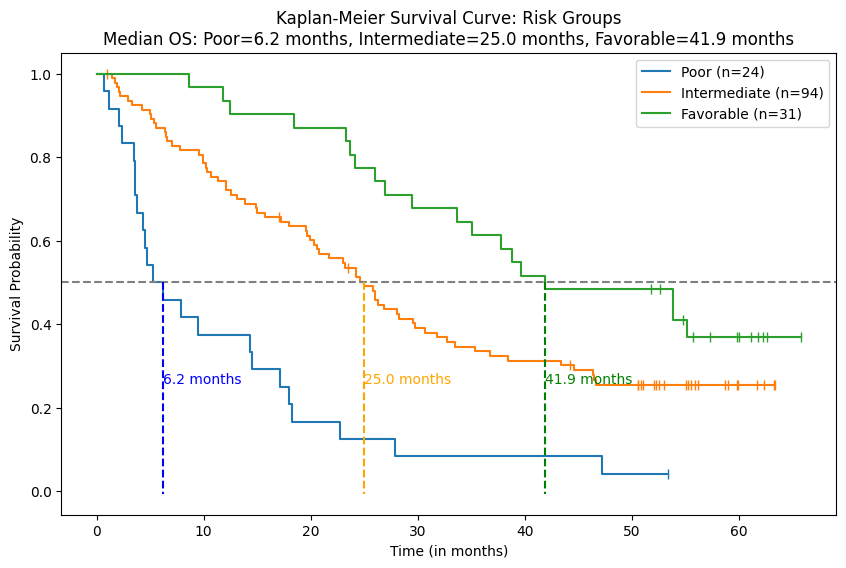

<Figure size 640x480 with 0 Axes>

In [70]:
# making 3 groups based on predicted OS and perfroing KM plot and cox model
results_os_both, plt = km_plot_cox_3_risk_groups(all_risks_both, all_durations_both, all_events_both, n_poor=24, n_favorable=31)
results_os_both['Log-rank p-value'] = results_os_both['Log-rank p-value'].apply(lambda x: '{:.2e}'.format(x))
plt.savefig(f'{model_path}/KM_plot_3_groups_OS_boht_vae.png')
results_os_both.to_csv(f'{model_path}/cox_results_3_groups_OS_both_vae.csv')

In [71]:
results_os_both

,Log-rank p-value,HR,Lower 95% CI,Upper 95% CI
Comparison,,,,
Poor vs Intermediate,6.54e-06,2.895040,1.786490,4.691468
Poor vs Favorable,8.38e-09,6.047022,3.081190,11.867644
Intermediate vs Favorable,2.33e-02,1.791417,1.074903,2.985548


## Removing IMDC NA

In [55]:
y_data_test['IMDC ORDINAL'].value_counts()

IMDC ORDINAL
1.0    86
0.0    34
2.0    23
Name: count, dtype: int64

In [56]:
# Convert lists to pandas Series and align the index with y_data_test
all_risks_os_series = pd.Series(all_risks_both, index=y_data_test.index)
all_durations_os_series = pd.Series(all_durations_both, index=y_data_test.index)
all_events_os_series = pd.Series(all_events_both, index=y_data_test.index)

# Create a mask to filter rows where 'IMDC' is not NaN
mask = y_data_test['IMDC ORDINAL'].notna()

# Apply the mask to filter the Series
filtered_risks_os = all_risks_os_series[mask].tolist()
filtered_durations_os = all_durations_os_series[mask].tolist()
filtered_events_os = all_events_os_series[mask].tolist()

# Now you have filtered lists
len(filtered_risks_os), len(filtered_durations_os), len(filtered_events_os)


(143, 143, 143)

In [83]:
model_path

'/home/leilapirhaji/finetune_unsupervised_VAE/pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1/trial_143/NIVO_OS_synergistic_EVER_OS/TL_NIVO_OS_best_model_grid_search'

saving plot to  /home/leilapirhaji/finetune_unsupervised_VAE/pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1/trial_143/NIVO_OS_synergistic_EVER_OS/TL_NIVO_OS_best_model_grid_search/KM_plot_3_groups_OS_boht_vae_IMDC_only.png


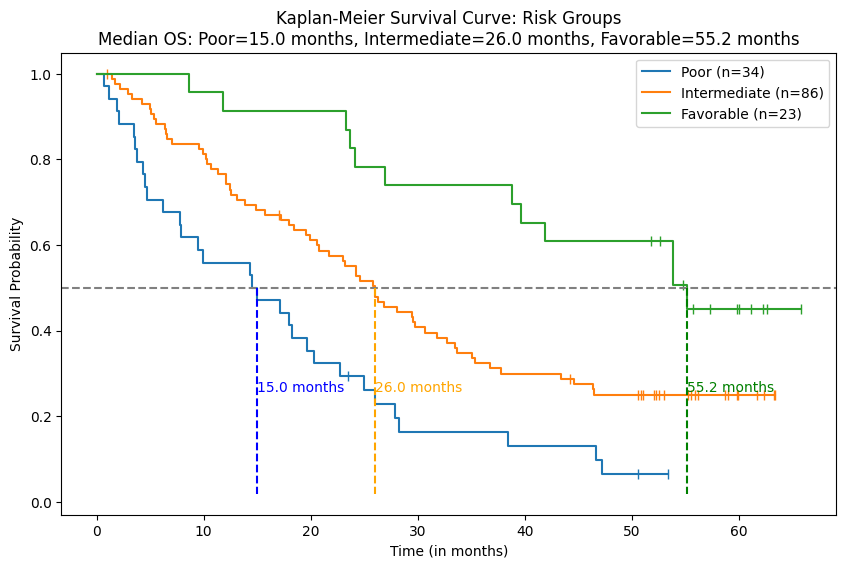

In [87]:
# making 3 groups based on predicted OS and perfroing KM plot and cox model
png_file=f'{model_path}/KM_plot_3_groups_OS_boht_vae_IMDC_only.png'

results_os_IMDC = km_plot_cox_3_risk_groups(filtered_risks_os, filtered_durations_os, filtered_events_os, png_file, n_poor=34, n_favorable=23)

results_os_IMDC['Log-rank p-value'] = results_os_IMDC['Log-rank p-value'].apply(lambda x: '{:.2e}'.format(x))
results_os_IMDC.to_csv(f'{model_path}/cox_results_3_groups_OS_both_IMDC_only.csv')

In [84]:
results_os_IMDC

,Log-rank p-value,HR,Lower 95% CI,Upper 95% CI
Comparison,,,,
Poor vs Intermediate,2.00e-03,1.958638,1.269001,3.023057
Poor vs Favorable,1.16e-06,5.580751,2.598543,11.985479
Intermediate vs Favorable,8.83e-03,2.244314,1.205926,4.176828


### Binary KM plots

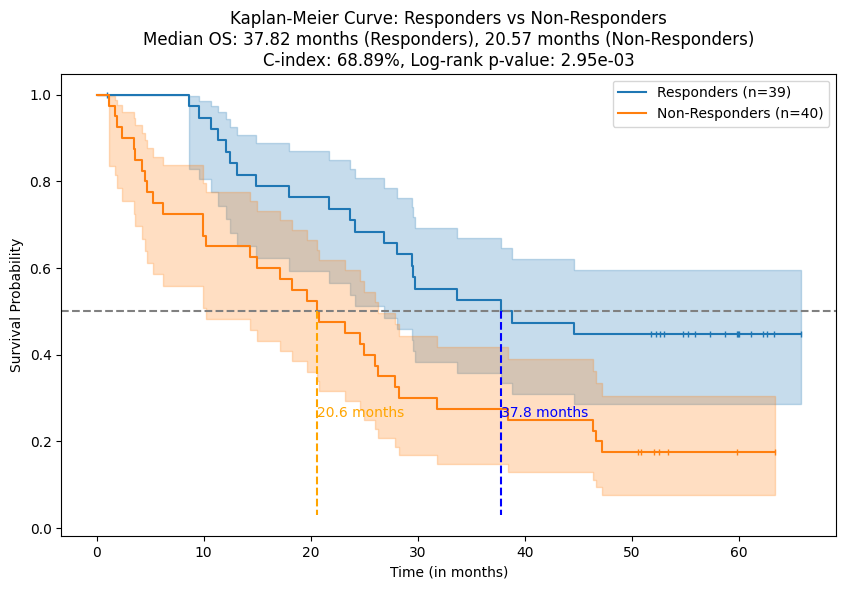

In [79]:
png_file=f'{model_path}/KM_plot_NIVO_OS.png'
km_plot_cox_2_risk_groups(all_risks_nivo, all_durations_nivo, all_events_nivo, png_file, risk_threshold=np.median(all_risks_nivo),c_index=metrics_test_nivo['C-index'][0])

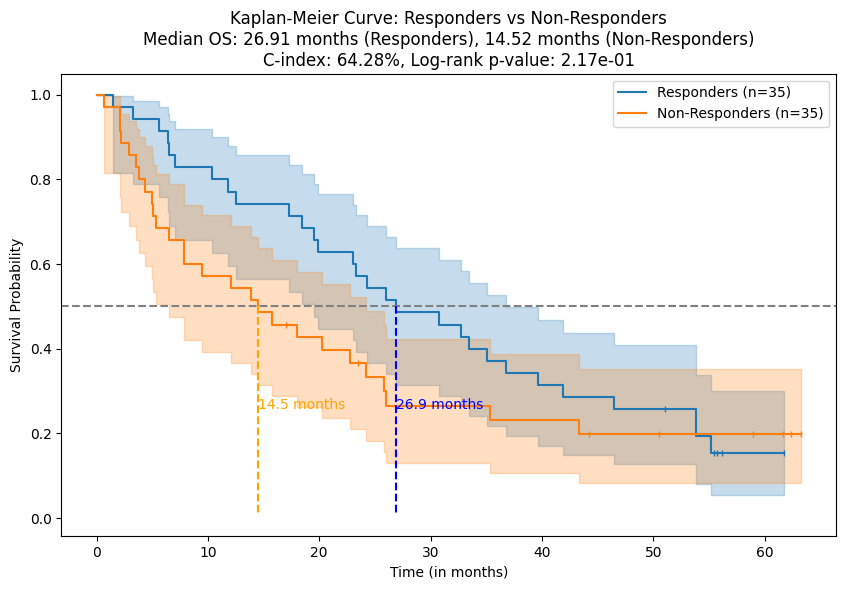

In [81]:
png_file=f'{model_path}/KM_plot_Evero_OS.png'

km_plot_cox_2_risk_groups(all_risks_evero, all_durations_evero, all_events_evero, png_file, risk_threshold=np.median(all_risks_evero), c_index=metrics_test_evero['C-index'][0])